# Data Processing

This script represents a full pipeline of image data extraction from the US Wildfire Dataset to
labelled TensorFlow tensors of satellite imagery.

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import sqlite3
import pandas as pd
import geopandas
import numpy as np
import tensorflow as tf
import datetime
import os
import ee  # this should be 0.1.175 to do folium plotting
import matplotlib.pyplot as plt
import folium
import tqdm
import dateutil.parser
from collections import OrderedDict
plt.style.use("default")
ee.Initialize()

import data_utils

In [3]:
cnx = sqlite3.connect('../us_wildfire_dataset/FPA_FOD_20170508.sqlite')

query = "SELECT FPA_ID, DISCOVERY_DATE, CONT_DATE, LATITUDE, LONGITUDE, STATE, FIRE_NAME, FIRE_SIZE_CLASS, FIRE_SIZE, STAT_CAUSE_DESCR FROM fires;"
df = pd.read_sql_query(query, cnx)

In [4]:
print("Causes: \n", pd.unique(df["STAT_CAUSE_DESCR"]))

Causes: 
 ['Miscellaneous' 'Lightning' 'Debris Burning' 'Campfire' 'Equipment Use'
 'Arson' 'Children' 'Railroad' 'Smoking' 'Powerline' 'Structure'
 'Fireworks' 'Missing/Undefined']


In [5]:
start_date = "2002-01-01"
end_date = "2020-05-04"
selected_causes = ["Lightning", "Debris Burning", "Miscellaneous", "Missing/Undefined"]

df_filt = data_utils.filter_fire_df(df, state="CA", min_class="D", start_date=start_date, end_date=end_date, causes=selected_causes)
df_filt.sort_values(by="size", ascending=False).head()

,fpa_id,start_date,end_date,geometry,name,size_class,size,cause,start_date_iso,end_date_iso
2269,W-647960,2012-08-12,2012-10-22,POINT (-120.11530 40.61530),RUSH,71,315578.8,Lightning,2012-08-12T00:00:00,2012-10-22T00:00:00
2387,FS-1519215,2013-08-17,2013-10-24,POINT (-120.08306 37.86056),RIM,71,255858.0,Miscellaneous,2013-08-17T00:00:00,2013-10-24T00:00:00
1788,FS-1458086,2007-10-21,2007-10-31,POINT (-116.71111 33.07444),WITCH,71,197990.0,Miscellaneous,2007-10-21T00:00:00,2007-10-31T00:00:00
1832,FS-1460100,2008-06-21,2008-07-27,POINT (-121.65833 36.28111),BASIN COMPLEX,71,162818.0,Lightning,2008-06-21T00:00:00,2008-07-27T00:00:00
1658,FS-1443777,2006-09-04,2006-10-30,POINT (-118.76972 34.63222),DAY,71,162702.0,Debris Burning,2006-09-04T00:00:00,2006-10-30T00:00:00


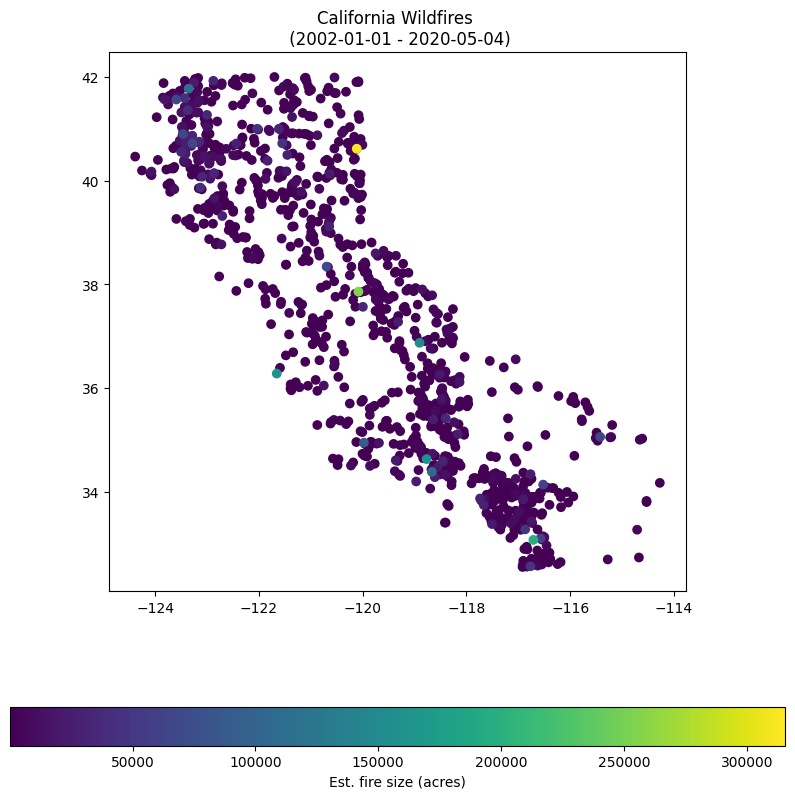

In [6]:
df_filt.sort_values(by="size").plot(column="size",
                                    legend=True,
                                    figsize=(10, 10),
                                    legend_kwds={"label": "Est. fire size (acres)", "orientation": "horizontal"})

plt.title("California Wildfires \n ({} - {})".format(start_date, end_date))
plt.show()

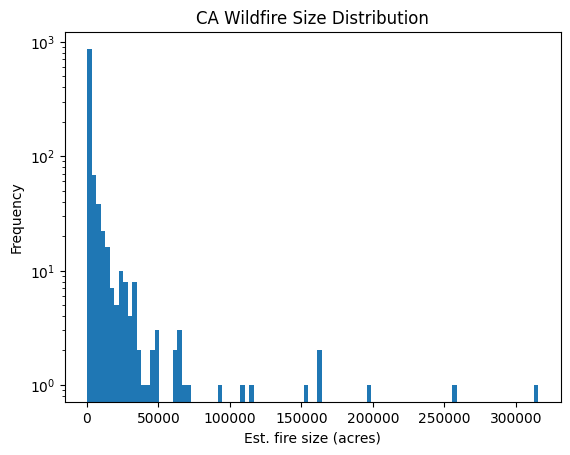

In [7]:
plt.hist(df_filt["size"], bins=100, log=True)
plt.xlabel("Est. fire size (acres)")
plt.ylabel("Frequency")
plt.title("CA Wildfire Size Distribution")
plt.show()

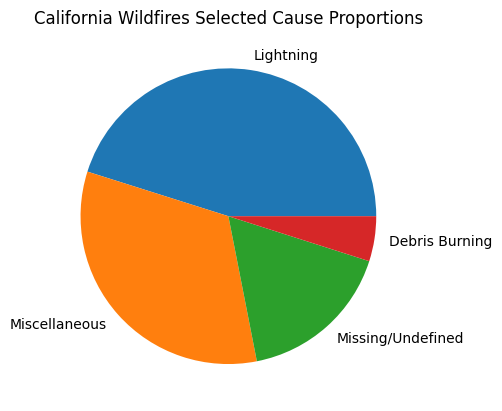

In [8]:
cause_counts = df_filt["cause"].value_counts()
plt.pie(cause_counts, labels=cause_counts.index)
plt.title("California Wildfires Selected Cause Proportions")
plt.show()

In [12]:
# create GEE FeatureCollection
feature_list = []
for _, row in df_filt.iterrows():

  properties = {
                "fpa_id": row["fpa_id"],
                "start_date": row["start_date_iso"],
                "end_date": row["end_date_iso"],
                "fire_bool": 1}

  feature = ee.Feature(ee.Geometry.Point(*row["geometry"].coords), properties)
  feature_list.append(feature)

label_data = ee.FeatureCollection(feature_list).limit(10)

In [14]:
# Get coords for map center
center = label_data.limit(100).geometry().centroid().getInfo()['coordinates']
center.reverse() # reverse for folium

# Load the first 100 points of the labels
dicc = {'train': label_data.limit(100).draw(**{'color': 'FF0000', 'strokeWidth': 5}).getMapId()}

# Load the imagery from the satellite
L7SR = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')
BANDS = ['B3', 'B2', 'B1']
visParams = {
  "bands": BANDS,
  "min": 0,
  "max": 3000,
  "gamma": 1.4,
}
label_region = label_data.limit(100).geometry().convexHull()
image = L7SR.filterDate('2018-01-01', '2018-12-31').filterBounds(label_region).map(data_utils.cloudMaskL457).median()

# Vizualize the imagery
imageid = image.getMapId(vis_params=visParams)
dicc['image'] = imageid

# Changing the order of the dictionary
key_order = ['image','train']
dicc = OrderedDict((k, dicc[k]) for k in key_order)

data_utils.Mapdisplay(center,dicc,zoom_start=6)

# Extract time-seres image data at label_data points

In [47]:
BUCKET = "cs231-firefighters"

FOLDER = "us_wildfire_dataset/us_fires_landsat7_positive_labels"

L7SR = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR')
BANDS = ['B3', 'B2', 'B1']
SCALARS = ["fire_index", "x_coord", "y_coord", "y"]
STRINGS = ["fpa_id", "img_date"]

TRAIN_FILE_PREFIX = 'Training_us_fires'
file_extension = '.tfrecord.gz'

KERNEL_SIZE = 128

In [38]:
def extractSingleDataSample(g, composite_days=30, date=None):
  """
  Extracts a single image compositing the SAT imagery <day_range> days BEFORE 
  the start date.

  If date is None, then the fire start date is used. Otherwise, it should
  be a ee.Date or ISO datestring object pre-populated with the desired date. 
  """

  # this is how it was done in the example work flow. No idea what this repetition is
  my_list = ee.List.repeat(1, KERNEL_SIZE)
  lists = ee.List.repeat(my_list, KERNEL_SIZE)
  kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

  # create date range (from custom start date or provided start date)
  if date is None:
    feature = ee.Feature(label_data_list.get(int(g))) # you need this int here else it gives a serialize error
    date = ee.Date(feature.get('start_date'))
  else:
    date = ee.Date(date)

  dateRange = ee.DateRange(date.advance(-composite_days, 'day'), date)

  # filter image collection by date range
  L7SR_processed = L7SR.filterDate(dateRange).map(data_utils.cloudMaskL457).median()
  L7SR_processed = L7SR_processed.select(BANDS)
  L7SR_neighborhood = L7SR_processed.neighborhoodToArray(kernel)

  # sampling from neighborhood gives (kernel_size x kernel_size image at feature.geometry())
  sample = L7SR_neighborhood.sample(region = ee.Feature(label_data_list.get(int(g))).geometry(), scale = 30, tileScale = 8, dropNulls=False)

  return sample

def extractTimeSeriesImages(g, iterations_to_collect_prior=12, composite_days=30):
  """
  This function extracts images at a location defined by feature[g] across a 
  time series. The resolution_days param will determine how much time will be
  composited together for a single time instance.

  If composite_days == 30, and iterations_to_collect_prior == 12, then this
  is effectively getting 12 images of the location over the past 12 months
  (each of size 30 days)
  """

  feature = ee.Feature(label_data_list.get(int(g))) # you need this int here else it gives a serialize error

  # unpack label info
  coords = feature.geometry().getInfo()["coordinates"]
  fire_bool = feature.get('fire_bool').getInfo()
  fpa_id = feature.get('fpa_id').getInfo()

  # unpack date info
  start_date = ee.Date(feature.get('start_date')).format().getInfo()  # get in ISO format
  start_date = dateutil.parser.parse(start_date)  # convert to datetime obj

  # get list of ISO strings representing dates in time series
  dates = [start_date - datetime.timedelta(days=i*(composite_days + 1)) for i in range(iterations_to_collect_prior)]
  dates = list(map(lambda x: x.isoformat(), dates))  # convert to ISO
  dates.reverse()

  # get time series images
  timeSeries = ee.FeatureCollection([])
  for date in dates:
    sample = ee.Image(extractSingleDataSample(g, composite_days=composite_days, date=date))
    timeSeries = ee.FeatureCollection(timeSeries.merge(sample))

  # label the time series images in a separate loop
  out = ee.FeatureCollection([])
  timeSeries_list = timeSeries.toList(timeSeries.size())
  for i, date in enumerate(dates):

    properties = {
      "fire_index": ee.Number(int(g)),
      "img_date": ee.String(date),
      "y": ee.Number(int(fire_bool)),
      "x_coord": ee.Number(coords[0]),
      "y_coord": ee.Number(coords[1]),
      "fpa_id": ee.String(fpa_id)
    }

    img_feat = ee.Feature(timeSeries_list.get(int(i)))
    out = out.merge(ee.Feature(img_feat.set(properties)))

  return out

In [157]:
# sanity check (make sure it has all the properties you want)
label_data_list = label_data.toList(label_data.size())
out = extractTimeSeriesImages(0)
out.first().propertyNames().getInfo()

['system:index',
 'fpa_id',
 'y_coord',
 'x_coord',
 'y',
 'img_date',
 'fire_index',
 'B2',
 'B3',
 'B1']

In [158]:
# Convert the feature collections to lists for iteration.
label_data_list = label_data.toList(label_data.size())

# Keep track of our tasks
tasks = [] 

# Create batches of the label_points for GEE to process / export
MAX_BATCH_SIZE = 100
batches = data_utils.create_batches(label_data, max_batch_size=MAX_BATCH_SIZE)

# Run the extraction
for batch in tqdm.tqdm(batches):
  geomSample = ee.FeatureCollection([])
  for g in batch:
    sample = ee.FeatureCollection(extractTimeSeriesImages(g))
    geomSample = geomSample.merge(sample)

  desc = TRAIN_FILE_PREFIX + '_g' + str(g)  # weirdly, it seems the "_g" is actually necessary... wtf
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + "/" + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + SCALARS + STRINGS
  )
  task.start()
  tasks.append(task)

100%|██████████| 2/2 [01:03<00:00, 31.82s/it]


In [159]:
data_utils.watch_task_list(tasks)

100%|██████████| 2/2 [00:14<00:00,  7.31s/it]


In [67]:
# These helper functions adopted from ex TF/GEE workflow notebook
def parse_tfrecord(example_proto):
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def format_tensor_and_scalars(inputs):
    # convert BANDS to 3d tensors
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    band_tensor = stacked
    # convert SCALARS to dictionary of rank-1 tensors
    scalars_dict = {thisKey : inputs[thisKey] for thisKey in SCALARS + STRINGS}
    return band_tensor, scalars_dict 


def get_dataset(pattern):
    glob = tf.io.gfile.glob(pattern)
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(format_tensor_and_scalars, num_parallel_calls=5)
    return dataset


def get_training_dataset():
	glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAIN_FILE_PREFIX + '*'
	dataset = get_dataset(glob)
	dataset = dataset.batch(32)
	return dataset

In [68]:
#!gcloud auth application-default login
!gcloud config set project simp-cs231n

Updated property [core/project].


In [69]:
# Specify inputs (Landsat bands) to the model and the response variable (to be implemented).
opticalBands = ['B3', 'B2', 'B1']
BANDS = opticalBands
SCALARS = ["fire_index", "x_coord", "y_coord", "y"]
STRINGS = ["fpa_id", "img_date"]
FEATURES = BANDS + SCALARS + STRINGS

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 128
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32, default_value=tf.zeros(KERNEL_SHAPE)) for k in BANDS
]
COLUMNS += [
  tf.io.FixedLenFeature(shape=1, dtype=tf.float32) for k in SCALARS       
]
COLUMNS += [
  tf.io.FixedLenFeature(shape=1, dtype=tf.string) for k in STRINGS       
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

dataset = get_training_dataset()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


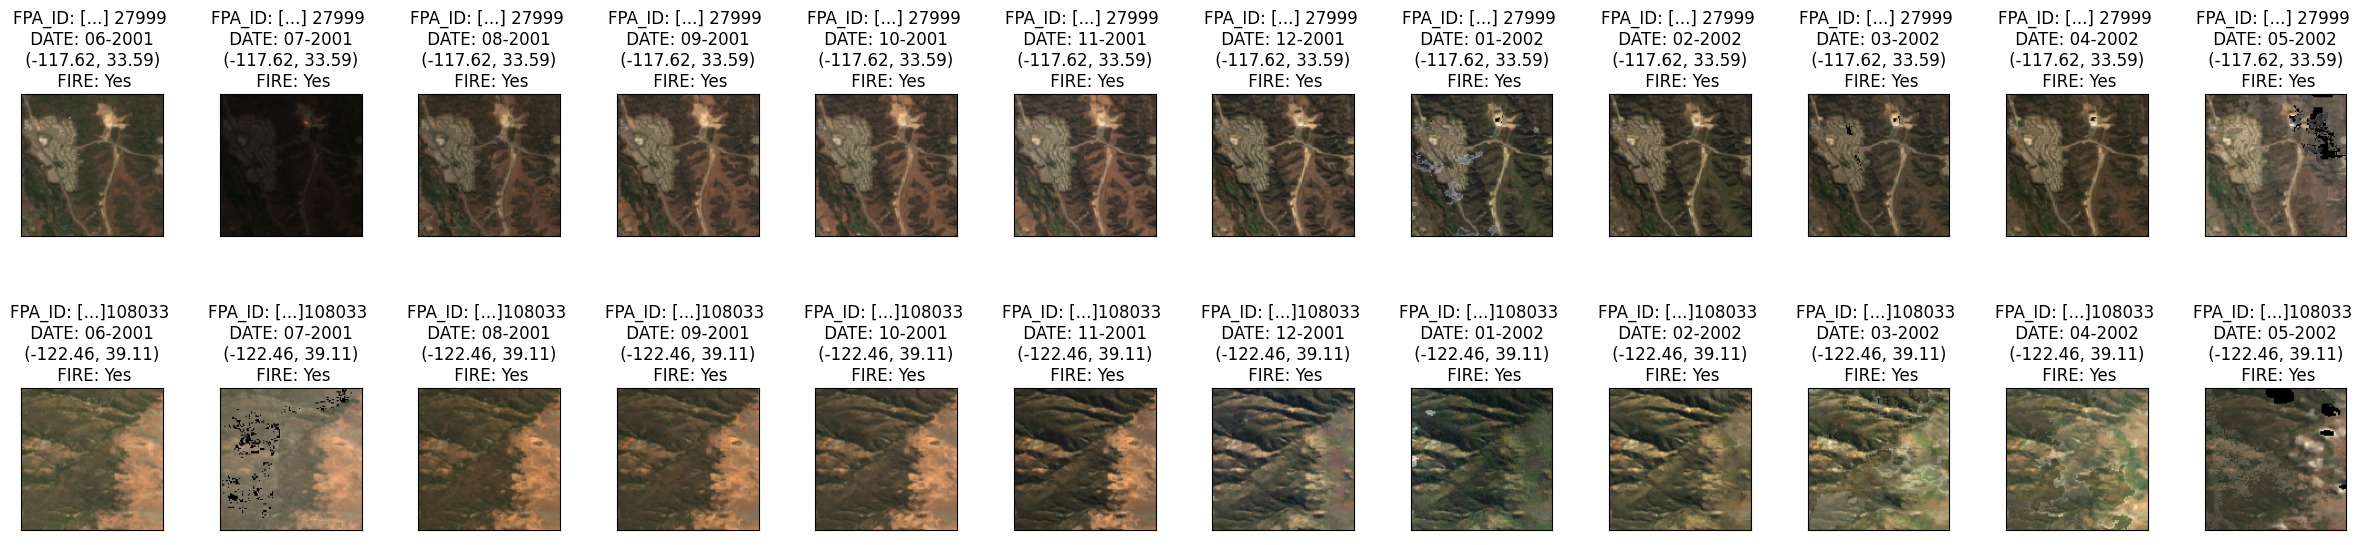

In [71]:
test_x, test_y = iter(dataset.take(1)).next()

x = test_x.numpy()

# Let's see some examples
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 12, figsize=(30, 7))
c = 0
for i in range(2):
  for j in range(12):
    axs[i][j].imshow(test_x[c] / np.max(test_x[c]))

    title = "FPA_ID: [...]{} \n DATE: {} \n ({:.2f}, {:.2f}) \n FIRE: {}".format(test_y["fpa_id"].numpy()[c][0].decode('utf-8')[-6:],
                                                                                    dateutil.parser.parse(test_y["img_date"].numpy()[c][0].decode('utf-8')).strftime("%m-%Y"),
                                                                                    test_y["x_coord"].numpy()[c][0],
                                                                                    test_y["y_coord"].numpy()[c][0],
                                                                                    "Yes" if test_y["y"].numpy()[c][0] == 1 else "No")

    axs[i][j].set_title(title)
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    c += 1


plt.subplots_adjust(wspace=0.4)
plt.show()